Spoken digit recognition using the Free Spoken Digit Dataset (FSDD)

At first, import packages to be used for the experiments

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm
import time

from sklearn.base import clone
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay, silhouette_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
from joblib import Parallel, delayed
from pyrcn.echo_state_network import ESNRegressor
from pyrcn.linear_model import IncrementalRegression
from pyrcn.base import InputToNode, NodeToNode
import matplotlib
from matplotlib import pyplot as plt
#Options
params = {'image.cmap' : 'RdBu',
          'text.usetex' : True,
          'font.size' : 11,
          'axes.titlesize' : 24,
          'axes.labelsize' : 20,
          'lines.linewidth' : 3,
          'lines.markersize' : 10,
          'xtick.labelsize' : 16,
          'ytick.labelsize' : 16,
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

import librosa

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


Print number of files that are included in the dataset

In [2]:
all_files = glob.glob(r"E:\free-spoken-digit-dataset\recordings\*.wav")
print(len(all_files))

3000


Feature visualization

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


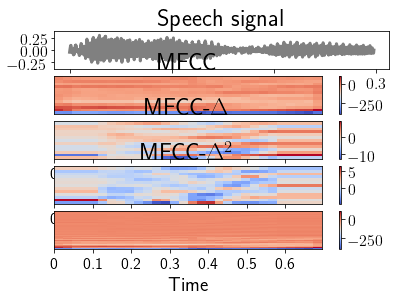

In [3]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
# X = np.vstack((mfcc, mfcc_delta, mfcc_delta2))
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(5, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(5, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(5, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(5, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(5, 1, 5)
librosa.display.specshow(np.vstack((mfcc, mfcc_delta, mfcc_delta2)), x_axis='time')
plt.colorbar()
plt.tight_layout()

Extract features and labels from all signals

In [4]:
X_train = []
X_test = []
y_train = []
y_test = []
print("extracting features...")
with tqdm(total=len(all_files)) as pbar:
    for k, f in enumerate(all_files):
        basename = os.path.basename(f).split('.')[0]
        # Get label (0-9) of recording.
        label = int(basename.split('_')[0])
        idx = int(basename.split('_')[2])
        # Load the audio signal and normalize it.
        x, sr = librosa.core.load(f, sr=None, mono=False)
        # x /= np.max(np.abs(x))
        mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        if idx <= 4:
            X_test.append(mfcc.T)
            y_test.append(label)
        else:
            X_train.append(mfcc.T)
            y_train.append(label)
        pbar.update(1)
print("done!")

extracting features...


100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:15<00:00, 197.41it/s]


done!


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1, stratify=y_train)

Validate training and test sizes

In [6]:
print(len(X_train), len(y_train), X_train[0].shape, y_train[0])
print(len(X_val), len(y_val), X_val[0].shape, y_val[0])
print(len(X_test), len(y_test), X_test[0].shape, y_test[0])

2430 2430 (50, 13) 1
270 270 (41, 13) 8
300 300 (30, 13) 0


## Normalize all features using the StandardScaler from scikit-learn.

In [7]:
scaler = StandardScaler().fit(X=np.vstack(X_train))
X_train_scaled = [scaler.transform(X) for X in X_train]
X_val_scaled = [scaler.transform(X) for X in X_val]
X_test_scaled = [scaler.transform(X) for X in X_test]

Feature visualization

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\matplotlib\tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


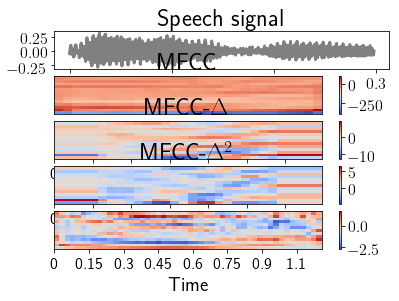

In [8]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(5, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(5, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(5, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(5, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(5, 1, 5)
librosa.display.specshow(X_train_scaled[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()

One-Hot encoding of labels

In [9]:
enc = OneHotEncoder(sparse=False).fit(X=np.asarray(y_train).reshape(-1, 1))

Random experiments

In [10]:
for rs in range(20):
    base_input_to_nodes = InputToNode(hidden_layer_size=500, activation='identity', k_in=X_train_scaled[0].shape[1], input_scaling=0.4, bias_scaling=0.0, random_state=rs)
    base_nodes_to_nodes = NodeToNode(hidden_layer_size=500, activation='tanh', spectral_radius=0.1, leakage=0.1, bias_scaling=0.0, bi_directional=False, k_rec=10, random_state=rs)

    base_esn = ESNRegressor(input_to_nodes=[('default', base_input_to_nodes)],
                            nodes_to_nodes=[('default', base_nodes_to_nodes)],
                            regressor=IncrementalRegression(alpha=1e-3), random_state=rs)
    print("Train the ESN model...")
    esn = clone(base_esn)
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y)
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    print("MSE test: %f\n" % (np.mean(mse_test)))


Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FAE8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89FBF8,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCEF89FD08,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9566929134 1.0000000000 0.9778672032       243
         


MSE training: 0.037021

Classification test report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FE18))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3A02158,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCF3A02048,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.8823529412 1.0000000000 0.9375000000        30
           1  1.00000


MSE test: 0.041489

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FE18))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3A7C158,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCF3A7C048,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9418604651 1.0000000000 0.970059880


MSE training: 0.037016

Classification test report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F8C8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F598,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCEF89F9D8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355        30
           1  0.96774


MSE test: 0.041412

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F9D8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCEF89F598,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9450980392 0.9917695473 0.967871485


MSE training: 0.037064

Classification test report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FD08))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89FAE8,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCEF89FBF8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9090909091 1.0000000000 0.9523809524        30
           1  1.00000


MSE test: 0.041837

Train the ESN model...
... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89FD08,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCEF89FAE8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9382239382 1.0000000000 0.968127490


MSE training: 0.036866

Classification test report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FE18))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.0, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3AEC158,
                                         sparsity=0.02, spectral_radius=0.1))],
             random_state=RandomState(MT19937) at 0x1FCF3AEC048,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9375000000 1.0000000000 0.9677419355        30
           1  1.00000


MSE test: 0.040967



Initialize an Echo State Network

In [26]:
base_input_to_nodes = InputToNode(hidden_layer_size=400, activation='identity', k_in=X_train_scaled[0].shape[1], input_scaling=0.8, bias_scaling=0.0, random_state=1)
base_nodes_to_nodes = NodeToNode(hidden_layer_size=400, activation='tanh', spectral_radius=0.3, leakage=0.1, bias_scaling=0.6, bi_directional=False, k_rec=10, random_state=1)

base_esn = ESNRegressor(input_to_nodes=[('default', base_input_to_nodes)],
                        nodes_to_nodes=[('default', base_nodes_to_nodes)],
                        regressor=IncrementalRegression(alpha=1e-3), random_state=1)

Clone the base_esn and fit it on the training data

In [27]:
esn = clone(base_esn)
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y)
        pbar.update(1)
print("... done!")

Train the ESN model...


100%|██████████████████████████████████████████████████████████████████████████████| 2430/2430 [00:56<00:00, 43.36it/s]


... done!


Test the model on the training and test set

100%|█████████████████████████████████████████████████████████████████████████████| 2430/2430 [00:11<00:00, 215.82it/s]


Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0,
                                          hidden_layer_size=400,
                                          input_scaling=0.8, k_in=13,
                                          random_state=RandomState(MT19937) at 0x2930DB3F6A8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6,
                                         hidden_layer_size=400, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x2930DB3F8C8,
                                         sparsity=0.025,
                                         spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x2930DB3F7B8,
             regressor=IncrementalRegression(alph

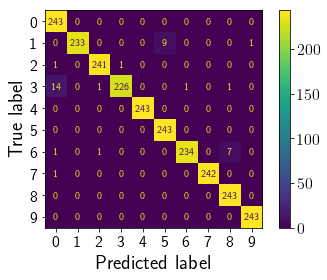

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 207.06it/s]


Classification test report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0,
                                          hidden_layer_size=400,
                                          input_scaling=0.8, k_in=13,
                                          random_state=RandomState(MT19937) at 0x2930DB3F6A8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6,
                                         hidden_layer_size=400, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x2930DB3F8C8,
                                         sparsity=0.025,
                                         spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x2930DB3F7B8,
             regressor=IncrementalRegression(alpha=0.

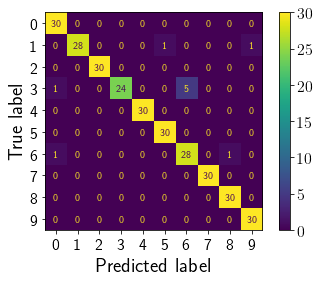

In [28]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))
plt.show()

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

Visualization of features from the training set

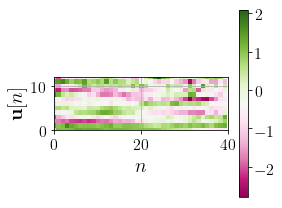

In [67]:
plt.figure(figsize=(4, 3))
im = plt.imshow(X_train_scaled[0].T,vmin=np.min(X_train_scaled[0]), vmax=np.max(X_train_scaled[0]))
plt.xlim([0,X_train_scaled[0].shape[0]])
plt.ylim([0, X_train_scaled[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('features_train.pdf')

Visualizations of features from the test set

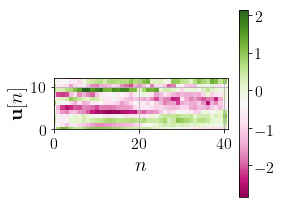

In [68]:
plt.figure(figsize=(4, 3))
im = plt.imshow(X_test_scaled[0].T,vmin=np.min(X_test_scaled[0]), vmax=np.max(X_test_scaled[0]))
plt.xlim([0, X_test[0].shape[0]])
plt.ylim([0, X_test[0].shape[1] - 1])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{u}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('features_test.pdf')

Visualization of a reservoir state from the training set

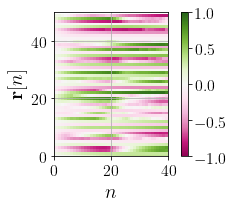

In [69]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_rand_train.pdf')

Visualization of a reservoir state from the test set

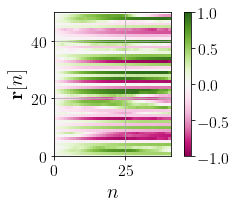

In [70]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_rand_test.pdf')

Random experiments

In [34]:
for rs in range(20):
    print("Train the ESN model...")
    kmeans = MiniBatchKMeans(n_clusters=500, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=rs)
    kmeans.fit(X=np.vstack(X_train_scaled))
    base_input_to_nodes = InputToNode(hidden_layer_size=500, activation='identity', k_in=X_train_scaled[0].shape[1], input_scaling=0.4, bias_scaling=0.0, random_state=rs)
    base_input_to_nodes.fit(X=X_train_scaled[0])
    w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
    base_input_to_nodes._input_weights = w_in
    base_nodes_to_nodes = NodeToNode(hidden_layer_size=500, activation='tanh', spectral_radius=0.3, leakage=0.1, bias_scaling=0.6, bi_directional=False, k_rec=10, random_state=rs)

    esn = ESNRegressor(input_to_nodes=[('default', base_input_to_nodes)],
                       nodes_to_nodes=[('default', base_nodes_to_nodes)],
                       regressor=IncrementalRegression(alpha=1e-3), random_state=rs)
    
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y)
    print("... done!")
    Y_true_train = []
    Y_pred_train = []
    mse_train = []
    mse_test = []
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
    print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
    print("MSE training: %f\n" % (np.mean(mse_train)))
    
    Y_true_test = []
    Y_pred_test = []
    mse_test = []
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
    print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
    print("MSE test: %f\n" % (np.mean(mse_test)))


Train the ESN model...


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9455252918 1.0000000000 0.9720000000       243
           1  1.0000000000 0.983

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F598))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F9D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.979

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.979

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F9D8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F598,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.975

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9642857143 1.0000000000 0.9818181818       243
           1  1.0000000000 0.983

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F598))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F9D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9492187500 1.0000000000 0.9739478958       243
           1  1.0000000000 0.975

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9453125000 0.9958847737 0.9699398798       243
           1  0.9957983193 0.975

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F9D8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F598,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.975

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.983

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F598))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F9D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9310344828 1.0000000000 0.9642857143       243
           1  1.0000000000 0.987

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9720000000 1.0000000000 0.9858012170       243
           1  1.0000000000 0.995

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F9D8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F598,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9720000000 1.0000000000 0.9858012170       243
           1  1.0000000000 0.991

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.983

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F598))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F9D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  0.9958847737 0.995

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.991

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F9D8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F598,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9382239382 1.0000000000 0.9681274900       243
           1  1.0000000000 0.971

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.987

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F598))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F9D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9455252918 1.0000000000 0.9720000000       243
           1  1.0000000000 0.987

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89FBF8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCF3B269D8,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCF3B268C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9529411765 1.0000000000 0.9759036145       243
           1  1.0000000000 0.979

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=500. Setting it to 3*k
  init_size=init_size)


... done!
Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0, input_scaling=0.4,
                                          k_in=13,
                                          random_state=RandomState(MT19937) at 0x1FCEF89F9D8))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.6, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x1FCEF89F598,
                                         sparsity=0.02, spectral_radius=0.3))],
             random_state=RandomState(MT19937) at 0x1FCEF89F8C8,
             regressor=IncrementalRegression(alpha=0.001)):
              precision    recall  f1-score   support

           0  0.9418604651 1.0000000000 0.9700598802       243
           1  1.0000000000 0.975

K-Means Clustering

In [74]:
kmeans = MiniBatchKMeans(n_clusters=400, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=1, random_state=0)
kmeans.fit(X=np.vstack(X_train_scaled))

Init 1/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/3: 423.410164
Init 2/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 2/3: 367.871538
Init 3/3 with method: k-means++


C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1676: RuntimeWarning: init_size=300 should be larger than k=400. Setting it to 3*k
  init_size=init_size)


Inertia for init 3/3: 453.079851
Minibatch iteration 1/107900: mean batch inertia: 3.925448, ewa inertia: 3.925448 
Minibatch iteration 2/107900: mean batch inertia: 3.865168, ewa inertia: 3.925336 
Minibatch iteration 3/107900: mean batch inertia: 3.805754, ewa inertia: 3.925114 
Minibatch iteration 4/107900: mean batch inertia: 3.824663, ewa inertia: 3.924928 
Minibatch iteration 5/107900: mean batch inertia: 3.672357, ewa inertia: 3.924460 
Minibatch iteration 6/107900: mean batch inertia: 4.158481, ewa inertia: 3.924894 
Minibatch iteration 7/107900: mean batch inertia: 3.890212, ewa inertia: 3.924829 
Minibatch iteration 8/107900: mean batch inertia: 3.506759, ewa inertia: 3.924054 
Minibatch iteration 9/107900: mean batch inertia: 3.729900, ewa inertia: 3.923694 
Minibatch iteration 10/107900: mean batch inertia: 3.910341, ewa inertia: 3.923669 
Minibatch iteration 11/107900: mean batch inertia: 3.480057, ewa inertia: 3.922846 
Minibatch iteration 12/107900: mean batch inertia: 3

Minibatch iteration 98/107900: mean batch inertia: 2.996714, ewa inertia: 3.827427 
Minibatch iteration 99/107900: mean batch inertia: 3.431198, ewa inertia: 3.826691 
Minibatch iteration 100/107900: mean batch inertia: 3.101593, ewa inertia: 3.825346 
Minibatch iteration 101/107900: mean batch inertia: 3.076787, ewa inertia: 3.823958 
Minibatch iteration 102/107900: mean batch inertia: 3.146095, ewa inertia: 3.822700 
Minibatch iteration 103/107900: mean batch inertia: 3.220576, ewa inertia: 3.821583 
Minibatch iteration 104/107900: mean batch inertia: 2.993280, ewa inertia: 3.820047 
Minibatch iteration 105/107900: mean batch inertia: 3.099642, ewa inertia: 3.818710 
Minibatch iteration 106/107900: mean batch inertia: 3.209264, ewa inertia: 3.817580 
Minibatch iteration 107/107900: mean batch inertia: 2.811144, ewa inertia: 3.815713 
Minibatch iteration 108/107900: mean batch inertia: 3.063258, ewa inertia: 3.814317 
Minibatch iteration 109/107900: mean batch inertia: 3.148928, ewa i

Minibatch iteration 194/107900: mean batch inertia: 3.022382, ewa inertia: 3.702589 
Minibatch iteration 195/107900: mean batch inertia: 2.866038, ewa inertia: 3.701037 
Minibatch iteration 196/107900: mean batch inertia: 3.535045, ewa inertia: 3.700729 
Minibatch iteration 197/107900: mean batch inertia: 3.051758, ewa inertia: 3.699526 
Minibatch iteration 198/107900: mean batch inertia: 2.843352, ewa inertia: 3.697937 
Minibatch iteration 199/107900: mean batch inertia: 2.848933, ewa inertia: 3.696362 
Minibatch iteration 200/107900: mean batch inertia: 3.009862, ewa inertia: 3.695089 
Minibatch iteration 201/107900: mean batch inertia: 2.834130, ewa inertia: 3.693492 
Minibatch iteration 202/107900: mean batch inertia: 2.951435, ewa inertia: 3.692115 
Minibatch iteration 203/107900: mean batch inertia: 2.994904, ewa inertia: 3.690822 
Minibatch iteration 204/107900: mean batch inertia: 3.195723, ewa inertia: 3.689903 
Minibatch iteration 205/107900: mean batch inertia: 3.100218, ewa

Minibatch iteration 290/107900: mean batch inertia: 2.944386, ewa inertia: 3.590746 
Minibatch iteration 291/107900: mean batch inertia: 3.338261, ewa inertia: 3.590277 
Minibatch iteration 292/107900: mean batch inertia: 2.935736, ewa inertia: 3.589063 
Minibatch iteration 293/107900: mean batch inertia: 2.992356, ewa inertia: 3.587956 
Minibatch iteration 294/107900: mean batch inertia: 3.188115, ewa inertia: 3.587214 
Minibatch iteration 295/107900: mean batch inertia: 2.926883, ewa inertia: 3.585989 
Minibatch iteration 296/107900: mean batch inertia: 3.257425, ewa inertia: 3.585380 
Minibatch iteration 297/107900: mean batch inertia: 3.037599, ewa inertia: 3.584364 
Minibatch iteration 298/107900: mean batch inertia: 2.775064, ewa inertia: 3.582862 
Minibatch iteration 299/107900: mean batch inertia: 2.938259, ewa inertia: 3.581667 
Minibatch iteration 300/107900: mean batch inertia: 3.040834, ewa inertia: 3.580663 
Minibatch iteration 301/107900: mean batch inertia: 3.076890, ewa

Minibatch iteration 386/107900: mean batch inertia: 2.906000, ewa inertia: 3.496477 
Minibatch iteration 387/107900: mean batch inertia: 2.981702, ewa inertia: 3.495522 
Minibatch iteration 388/107900: mean batch inertia: 2.999626, ewa inertia: 3.494603 
Minibatch iteration 389/107900: mean batch inertia: 3.041612, ewa inertia: 3.493762 
Minibatch iteration 390/107900: mean batch inertia: 3.018440, ewa inertia: 3.492880 
Minibatch iteration 391/107900: mean batch inertia: 3.209409, ewa inertia: 3.492355 
Minibatch iteration 392/107900: mean batch inertia: 3.170910, ewa inertia: 3.491758 
Minibatch iteration 393/107900: mean batch inertia: 3.047656, ewa inertia: 3.490934 
Minibatch iteration 394/107900: mean batch inertia: 3.048330, ewa inertia: 3.490113 
Minibatch iteration 395/107900: mean batch inertia: 2.995038, ewa inertia: 3.489195 
Minibatch iteration 396/107900: mean batch inertia: 3.078944, ewa inertia: 3.488434 
Minibatch iteration 397/107900: mean batch inertia: 3.087474, ewa

Minibatch iteration 482/107900: mean batch inertia: 3.009802, ewa inertia: 3.410983 
Minibatch iteration 483/107900: mean batch inertia: 3.016100, ewa inertia: 3.410250 
Minibatch iteration 484/107900: mean batch inertia: 2.726808, ewa inertia: 3.408983 
Minibatch iteration 485/107900: mean batch inertia: 2.568798, ewa inertia: 3.407424 
Minibatch iteration 486/107900: mean batch inertia: 2.910520, ewa inertia: 3.406502 
Minibatch iteration 487/107900: mean batch inertia: 2.907996, ewa inertia: 3.405577 
Minibatch iteration 488/107900: mean batch inertia: 2.848562, ewa inertia: 3.404544 
Minibatch iteration 489/107900: mean batch inertia: 3.022002, ewa inertia: 3.403834 
Minibatch iteration 490/107900: mean batch inertia: 2.997815, ewa inertia: 3.403081 
Minibatch iteration 491/107900: mean batch inertia: 3.198018, ewa inertia: 3.402701 
Minibatch iteration 492/107900: mean batch inertia: 2.881430, ewa inertia: 3.401734 
Minibatch iteration 493/107900: mean batch inertia: 2.748071, ewa

Minibatch iteration 578/107900: mean batch inertia: 3.117110, ewa inertia: 3.336118 
Minibatch iteration 579/107900: mean batch inertia: 2.992107, ewa inertia: 3.335480 
Minibatch iteration 580/107900: mean batch inertia: 2.859473, ewa inertia: 3.334597 
Minibatch iteration 581/107900: mean batch inertia: 3.030689, ewa inertia: 3.334033 
Minibatch iteration 582/107900: mean batch inertia: 2.789170, ewa inertia: 3.333022 
Minibatch iteration 583/107900: mean batch inertia: 2.929179, ewa inertia: 3.332273 
Minibatch iteration 584/107900: mean batch inertia: 3.106712, ewa inertia: 3.331854 
Minibatch iteration 585/107900: mean batch inertia: 2.994630, ewa inertia: 3.331229 
Minibatch iteration 586/107900: mean batch inertia: 2.965377, ewa inertia: 3.330550 
Minibatch iteration 587/107900: mean batch inertia: 2.982353, ewa inertia: 3.329904 
Minibatch iteration 588/107900: mean batch inertia: 3.057538, ewa inertia: 3.329399 
Minibatch iteration 589/107900: mean batch inertia: 2.929432, ewa

Minibatch iteration 674/107900: mean batch inertia: 3.163352, ewa inertia: 3.267071 
Minibatch iteration 675/107900: mean batch inertia: 2.916126, ewa inertia: 3.266420 
Minibatch iteration 676/107900: mean batch inertia: 3.089893, ewa inertia: 3.266092 
Minibatch iteration 677/107900: mean batch inertia: 3.165060, ewa inertia: 3.265905 
Minibatch iteration 678/107900: mean batch inertia: 2.878538, ewa inertia: 3.265186 
Minibatch iteration 679/107900: mean batch inertia: 3.177968, ewa inertia: 3.265025 
Minibatch iteration 680/107900: mean batch inertia: 3.221213, ewa inertia: 3.264943 
Minibatch iteration 681/107900: mean batch inertia: 2.635579, ewa inertia: 3.263776 
Minibatch iteration 682/107900: mean batch inertia: 3.038353, ewa inertia: 3.263358 
Minibatch iteration 683/107900: mean batch inertia: 3.014839, ewa inertia: 3.262897 
Minibatch iteration 684/107900: mean batch inertia: 3.019177, ewa inertia: 3.262444 
Minibatch iteration 685/107900: mean batch inertia: 3.179153, ewa

Minibatch iteration 770/107900: mean batch inertia: 2.824756, ewa inertia: 3.214568 
Minibatch iteration 771/107900: mean batch inertia: 3.124126, ewa inertia: 3.214400 
Minibatch iteration 772/107900: mean batch inertia: 3.453242, ewa inertia: 3.214843 
Minibatch iteration 773/107900: mean batch inertia: 2.618851, ewa inertia: 3.213737 
Minibatch iteration 774/107900: mean batch inertia: 2.679180, ewa inertia: 3.212746 
Minibatch iteration 775/107900: mean batch inertia: 2.687626, ewa inertia: 3.211772 
Minibatch iteration 776/107900: mean batch inertia: 3.034027, ewa inertia: 3.211442 
Minibatch iteration 777/107900: mean batch inertia: 2.941640, ewa inertia: 3.210941 
Minibatch iteration 778/107900: mean batch inertia: 3.078428, ewa inertia: 3.210696 
Minibatch iteration 779/107900: mean batch inertia: 3.046532, ewa inertia: 3.210391 
Minibatch iteration 780/107900: mean batch inertia: 2.691119, ewa inertia: 3.209428 
Minibatch iteration 781/107900: mean batch inertia: 2.873599, ewa

Minibatch iteration 866/107900: mean batch inertia: 3.030612, ewa inertia: 3.163760 
Minibatch iteration 867/107900: mean batch inertia: 2.924541, ewa inertia: 3.163316 
Minibatch iteration 868/107900: mean batch inertia: 2.747809, ewa inertia: 3.162546 
Minibatch iteration 869/107900: mean batch inertia: 2.841306, ewa inertia: 3.161950 
Minibatch iteration 870/107900: mean batch inertia: 2.675093, ewa inertia: 3.161046 
Minibatch iteration 871/107900: mean batch inertia: 2.783902, ewa inertia: 3.160347 
Minibatch iteration 872/107900: mean batch inertia: 2.851217, ewa inertia: 3.159773 
Minibatch iteration 873/107900: mean batch inertia: 2.897063, ewa inertia: 3.159286 
Minibatch iteration 874/107900: mean batch inertia: 3.141167, ewa inertia: 3.159252 
Minibatch iteration 875/107900: mean batch inertia: 2.843197, ewa inertia: 3.158666 
Minibatch iteration 876/107900: mean batch inertia: 2.893669, ewa inertia: 3.158174 
Minibatch iteration 877/107900: mean batch inertia: 2.954511, ewa

Minibatch iteration 962/107900: mean batch inertia: 2.713110, ewa inertia: 3.120443 
Minibatch iteration 963/107900: mean batch inertia: 3.106347, ewa inertia: 3.120416 
Minibatch iteration 964/107900: mean batch inertia: 3.100380, ewa inertia: 3.120379 
Minibatch iteration 965/107900: mean batch inertia: 3.142082, ewa inertia: 3.120420 
Minibatch iteration 966/107900: mean batch inertia: 2.719805, ewa inertia: 3.119676 
Minibatch iteration 967/107900: mean batch inertia: 2.882334, ewa inertia: 3.119236 
Minibatch iteration 968/107900: mean batch inertia: 2.808144, ewa inertia: 3.118659 
Minibatch iteration 969/107900: mean batch inertia: 2.986150, ewa inertia: 3.118413 
Minibatch iteration 970/107900: mean batch inertia: 2.827382, ewa inertia: 3.117873 
Minibatch iteration 971/107900: mean batch inertia: 2.723545, ewa inertia: 3.117142 
Minibatch iteration 972/107900: mean batch inertia: 2.861895, ewa inertia: 3.116668 
Minibatch iteration 973/107900: mean batch inertia: 2.888079, ewa

Minibatch iteration 1057/107900: mean batch inertia: 2.855501, ewa inertia: 3.087071 
Minibatch iteration 1058/107900: mean batch inertia: 2.784152, ewa inertia: 3.086509 
Minibatch iteration 1059/107900: mean batch inertia: 3.062474, ewa inertia: 3.086465 
Minibatch iteration 1060/107900: mean batch inertia: 2.836205, ewa inertia: 3.086000 
Minibatch iteration 1061/107900: mean batch inertia: 2.981466, ewa inertia: 3.085807 
Minibatch iteration 1062/107900: mean batch inertia: 2.927488, ewa inertia: 3.085513 
Minibatch iteration 1063/107900: mean batch inertia: 3.076675, ewa inertia: 3.085496 
Minibatch iteration 1064/107900: mean batch inertia: 2.853695, ewa inertia: 3.085066 
Minibatch iteration 1065/107900: mean batch inertia: 2.698032, ewa inertia: 3.084348 
Minibatch iteration 1066/107900: mean batch inertia: 2.878381, ewa inertia: 3.083966 
Minibatch iteration 1067/107900: mean batch inertia: 2.949406, ewa inertia: 3.083717 
Minibatch iteration 1068/107900: mean batch inertia: 2

Minibatch iteration 1152/107900: mean batch inertia: 2.914404, ewa inertia: 3.055739 
Minibatch iteration 1153/107900: mean batch inertia: 2.882622, ewa inertia: 3.055418 
Minibatch iteration 1154/107900: mean batch inertia: 2.611189, ewa inertia: 3.054594 
Minibatch iteration 1155/107900: mean batch inertia: 2.909554, ewa inertia: 3.054325 
Minibatch iteration 1156/107900: mean batch inertia: 2.916399, ewa inertia: 3.054069 
Minibatch iteration 1157/107900: mean batch inertia: 2.912557, ewa inertia: 3.053806 
Minibatch iteration 1158/107900: mean batch inertia: 2.942631, ewa inertia: 3.053600 
Minibatch iteration 1159/107900: mean batch inertia: 2.757343, ewa inertia: 3.053051 
Minibatch iteration 1160/107900: mean batch inertia: 2.693149, ewa inertia: 3.052383 
Minibatch iteration 1161/107900: mean batch inertia: 2.690877, ewa inertia: 3.051712 
Minibatch iteration 1162/107900: mean batch inertia: 3.132671, ewa inertia: 3.051862 
Minibatch iteration 1163/107900: mean batch inertia: 3

Minibatch iteration 1247/107900: mean batch inertia: 2.837543, ewa inertia: 3.033887 
Minibatch iteration 1248/107900: mean batch inertia: 2.985609, ewa inertia: 3.033797 
Minibatch iteration 1249/107900: mean batch inertia: 3.084353, ewa inertia: 3.033891 
Minibatch iteration 1250/107900: mean batch inertia: 3.083420, ewa inertia: 3.033983 
Minibatch iteration 1251/107900: mean batch inertia: 3.018684, ewa inertia: 3.033955 
Minibatch iteration 1252/107900: mean batch inertia: 2.818750, ewa inertia: 3.033555 
Minibatch iteration 1253/107900: mean batch inertia: 2.697884, ewa inertia: 3.032933 
Minibatch iteration 1254/107900: mean batch inertia: 2.854721, ewa inertia: 3.032602 
Minibatch iteration 1255/107900: mean batch inertia: 2.853737, ewa inertia: 3.032270 
Minibatch iteration 1256/107900: mean batch inertia: 2.913812, ewa inertia: 3.032051 
Minibatch iteration 1257/107900: mean batch inertia: 2.845792, ewa inertia: 3.031705 
Minibatch iteration 1258/107900: mean batch inertia: 2

Minibatch iteration 1342/107900: mean batch inertia: 2.741061, ewa inertia: 3.016881 
Minibatch iteration 1343/107900: mean batch inertia: 2.962687, ewa inertia: 3.016781 
Minibatch iteration 1344/107900: mean batch inertia: 3.010000, ewa inertia: 3.016768 
Minibatch iteration 1345/107900: mean batch inertia: 3.100447, ewa inertia: 3.016924 
Minibatch iteration 1346/107900: mean batch inertia: 3.039825, ewa inertia: 3.016966 
Minibatch iteration 1347/107900: mean batch inertia: 2.964541, ewa inertia: 3.016869 
Minibatch iteration 1348/107900: mean batch inertia: 2.963626, ewa inertia: 3.016770 
Minibatch iteration 1349/107900: mean batch inertia: 2.966296, ewa inertia: 3.016676 
Minibatch iteration 1350/107900: mean batch inertia: 2.706867, ewa inertia: 3.016102 
Minibatch iteration 1351/107900: mean batch inertia: 2.745261, ewa inertia: 3.015599 
Minibatch iteration 1352/107900: mean batch inertia: 2.933523, ewa inertia: 3.015447 
Minibatch iteration 1353/107900: mean batch inertia: 2

Minibatch iteration 1437/107900: mean batch inertia: 3.036567, ewa inertia: 3.000304 
Minibatch iteration 1438/107900: mean batch inertia: 2.715925, ewa inertia: 2.999777 
Minibatch iteration 1439/107900: mean batch inertia: 3.030418, ewa inertia: 2.999833 
Minibatch iteration 1440/107900: mean batch inertia: 2.987695, ewa inertia: 2.999811 
Minibatch iteration 1441/107900: mean batch inertia: 2.749184, ewa inertia: 2.999346 
Minibatch iteration 1442/107900: mean batch inertia: 2.891866, ewa inertia: 2.999147 
Minibatch iteration 1443/107900: mean batch inertia: 2.905630, ewa inertia: 2.998973 
Minibatch iteration 1444/107900: mean batch inertia: 3.006877, ewa inertia: 2.998988 
Minibatch iteration 1445/107900: mean batch inertia: 2.898327, ewa inertia: 2.998801 
Minibatch iteration 1446/107900: mean batch inertia: 2.816426, ewa inertia: 2.998463 
Minibatch iteration 1447/107900: mean batch inertia: 3.021770, ewa inertia: 2.998506 
Minibatch iteration 1448/107900: mean batch inertia: 3

Minibatch iteration 1532/107900: mean batch inertia: 2.827054, ewa inertia: 2.985954 
Minibatch iteration 1533/107900: mean batch inertia: 3.059629, ewa inertia: 2.986091 
Minibatch iteration 1534/107900: mean batch inertia: 2.791661, ewa inertia: 2.985730 
Minibatch iteration 1535/107900: mean batch inertia: 2.845702, ewa inertia: 2.985471 
Minibatch iteration 1536/107900: mean batch inertia: 3.018255, ewa inertia: 2.985531 
Minibatch iteration 1537/107900: mean batch inertia: 2.824143, ewa inertia: 2.985232 
Minibatch iteration 1538/107900: mean batch inertia: 2.846464, ewa inertia: 2.984975 
Minibatch iteration 1539/107900: mean batch inertia: 2.685260, ewa inertia: 2.984419 
Minibatch iteration 1540/107900: mean batch inertia: 3.021863, ewa inertia: 2.984488 
Minibatch iteration 1541/107900: mean batch inertia: 2.991720, ewa inertia: 2.984501 
Minibatch iteration 1542/107900: mean batch inertia: 2.915761, ewa inertia: 2.984374 
Minibatch iteration 1543/107900: mean batch inertia: 3

Minibatch iteration 1627/107900: mean batch inertia: 2.434964, ewa inertia: 2.970555 
Minibatch iteration 1628/107900: mean batch inertia: 3.051063, ewa inertia: 2.970705 
Minibatch iteration 1629/107900: mean batch inertia: 3.032051, ewa inertia: 2.970818 
Minibatch iteration 1630/107900: mean batch inertia: 2.941392, ewa inertia: 2.970764 
Minibatch iteration 1631/107900: mean batch inertia: 2.867165, ewa inertia: 2.970572 
Minibatch iteration 1632/107900: mean batch inertia: 2.967958, ewa inertia: 2.970567 
Minibatch iteration 1633/107900: mean batch inertia: 3.006214, ewa inertia: 2.970633 
Minibatch iteration 1634/107900: mean batch inertia: 2.784862, ewa inertia: 2.970288 
Minibatch iteration 1635/107900: mean batch inertia: 2.781603, ewa inertia: 2.969938 
Minibatch iteration 1636/107900: mean batch inertia: 2.957724, ewa inertia: 2.969916 
Minibatch iteration 1637/107900: mean batch inertia: 2.952247, ewa inertia: 2.969883 
Minibatch iteration 1638/107900: mean batch inertia: 2

Minibatch iteration 1722/107900: mean batch inertia: 2.730616, ewa inertia: 2.960097 
Minibatch iteration 1723/107900: mean batch inertia: 2.947306, ewa inertia: 2.960073 
Minibatch iteration 1724/107900: mean batch inertia: 2.995006, ewa inertia: 2.960138 
Minibatch iteration 1725/107900: mean batch inertia: 2.856298, ewa inertia: 2.959945 
Minibatch iteration 1726/107900: mean batch inertia: 3.181469, ewa inertia: 2.960356 
Minibatch iteration 1727/107900: mean batch inertia: 3.223569, ewa inertia: 2.960845 
Minibatch iteration 1728/107900: mean batch inertia: 3.234467, ewa inertia: 2.961352 
Minibatch iteration 1729/107900: mean batch inertia: 3.098338, ewa inertia: 2.961606 
Minibatch iteration 1730/107900: mean batch inertia: 2.971801, ewa inertia: 2.961625 
Minibatch iteration 1731/107900: mean batch inertia: 2.902747, ewa inertia: 2.961516 
Minibatch iteration 1732/107900: mean batch inertia: 2.921253, ewa inertia: 2.961441 
Minibatch iteration 1733/107900: mean batch inertia: 2

Minibatch iteration 1817/107900: mean batch inertia: 2.865376, ewa inertia: 2.948854 
Minibatch iteration 1818/107900: mean batch inertia: 2.548184, ewa inertia: 2.948111 
Minibatch iteration 1819/107900: mean batch inertia: 2.755686, ewa inertia: 2.947754 
Minibatch iteration 1820/107900: mean batch inertia: 2.828120, ewa inertia: 2.947532 
Minibatch iteration 1821/107900: mean batch inertia: 3.041057, ewa inertia: 2.947705 
Minibatch iteration 1822/107900: mean batch inertia: 2.827183, ewa inertia: 2.947482 
Minibatch iteration 1823/107900: mean batch inertia: 2.986025, ewa inertia: 2.947553 
Minibatch iteration 1824/107900: mean batch inertia: 3.004468, ewa inertia: 2.947659 
Minibatch iteration 1825/107900: mean batch inertia: 2.940642, ewa inertia: 2.947646 
Minibatch iteration 1826/107900: mean batch inertia: 2.796413, ewa inertia: 2.947365 
Minibatch iteration 1827/107900: mean batch inertia: 2.880382, ewa inertia: 2.947241 
Minibatch iteration 1828/107900: mean batch inertia: 3

Minibatch iteration 1912/107900: mean batch inertia: 3.013053, ewa inertia: 2.942983 
Minibatch iteration 1913/107900: mean batch inertia: 2.573104, ewa inertia: 2.942297 
Minibatch iteration 1914/107900: mean batch inertia: 3.309943, ewa inertia: 2.942979 
Minibatch iteration 1915/107900: mean batch inertia: 2.949030, ewa inertia: 2.942991 
Minibatch iteration 1916/107900: mean batch inertia: 2.557580, ewa inertia: 2.942276 
Minibatch iteration 1917/107900: mean batch inertia: 3.126128, ewa inertia: 2.942617 
Minibatch iteration 1918/107900: mean batch inertia: 2.801361, ewa inertia: 2.942355 
Minibatch iteration 1919/107900: mean batch inertia: 2.583048, ewa inertia: 2.941688 
Minibatch iteration 1920/107900: mean batch inertia: 3.179684, ewa inertia: 2.942130 
Minibatch iteration 1921/107900: mean batch inertia: 2.888220, ewa inertia: 2.942030 
Minibatch iteration 1922/107900: mean batch inertia: 2.783524, ewa inertia: 2.941735 
Minibatch iteration 1923/107900: mean batch inertia: 2

Minibatch iteration 2007/107900: mean batch inertia: 2.796756, ewa inertia: 2.934877 
Minibatch iteration 2008/107900: mean batch inertia: 3.079421, ewa inertia: 2.935145 
Minibatch iteration 2009/107900: mean batch inertia: 3.001489, ewa inertia: 2.935268 
Minibatch iteration 2010/107900: mean batch inertia: 2.860726, ewa inertia: 2.935130 
Minibatch iteration 2011/107900: mean batch inertia: 2.829854, ewa inertia: 2.934935 
Minibatch iteration 2012/107900: mean batch inertia: 2.642009, ewa inertia: 2.934391 
Minibatch iteration 2013/107900: mean batch inertia: 3.057491, ewa inertia: 2.934619 
Minibatch iteration 2014/107900: mean batch inertia: 2.618820, ewa inertia: 2.934034 
Minibatch iteration 2015/107900: mean batch inertia: 2.647609, ewa inertia: 2.933502 
Minibatch iteration 2016/107900: mean batch inertia: 2.701183, ewa inertia: 2.933071 
Minibatch iteration 2017/107900: mean batch inertia: 2.742802, ewa inertia: 2.932718 
Minibatch iteration 2018/107900: mean batch inertia: 2

Minibatch iteration 2102/107900: mean batch inertia: 2.661925, ewa inertia: 2.925331 
Minibatch iteration 2103/107900: mean batch inertia: 2.952180, ewa inertia: 2.925381 
Minibatch iteration 2104/107900: mean batch inertia: 2.934816, ewa inertia: 2.925398 
Minibatch iteration 2105/107900: mean batch inertia: 2.972306, ewa inertia: 2.925485 
Minibatch iteration 2106/107900: mean batch inertia: 3.113321, ewa inertia: 2.925834 
Minibatch iteration 2107/107900: mean batch inertia: 3.238340, ewa inertia: 2.926413 
Minibatch iteration 2108/107900: mean batch inertia: 2.909447, ewa inertia: 2.926382 
Minibatch iteration 2109/107900: mean batch inertia: 2.909510, ewa inertia: 2.926351 
Minibatch iteration 2110/107900: mean batch inertia: 2.738339, ewa inertia: 2.926002 
Minibatch iteration 2111/107900: mean batch inertia: 3.152471, ewa inertia: 2.926422 
Minibatch iteration 2112/107900: mean batch inertia: 2.853812, ewa inertia: 2.926287 
Minibatch iteration 2113/107900: mean batch inertia: 2

MiniBatchKMeans(max_no_improvement=50, n_clusters=400, random_state=0,
                reassignment_ratio=0, verbose=1)

Compute distance to labels

In [41]:
new_train_features = [kmeans.transform(X) for X in X_train_scaled]
new_test_features = [kmeans.transform(X) for X in X_test_scaled]

Visualization

TypeError: predict() got an unexpected keyword argument 'keep_reservoir_state'

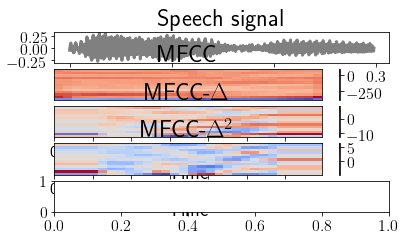

In [42]:
# Load the audio signal and normalize it.
basename = os.path.basename(all_files[0]).split('.')[0]
x, sr = librosa.core.load(all_files[0], sr=None, mono=False)
# x /= np.max(np.abs(x))
mfcc = librosa.feature.mfcc(y=x, sr=sr, hop_length=int(0.01*sr), n_fft=256, htk=True, n_mels=100, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
X = mfcc.T
label = int(basename.split('_')[0])
# Define time axis in seconds
t = np.arange(len(x)) / sr

plt.subplot(6, 1, 1)
plt.plot(t, x, color='gray')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Amplitude')
# plt.xlim([t[0], t[-1]])
# plt.ylim([-0.4, 0.4])
plt.title("Speech signal")
plt.subplot(6, 1, 2)
librosa.display.specshow(mfcc)
plt.title('MFCC')
plt.colorbar()
plt.subplot(6, 1, 3)
librosa.display.specshow(mfcc_delta, x_axis='time')
plt.title(r'MFCC-$\Delta$')
plt.colorbar()
plt.subplot(6, 1, 4)
librosa.display.specshow(mfcc_delta2, x_axis='time')
plt.title(r'MFCC-$\Delta^2$')
plt.colorbar()
plt.subplot(6, 1, 5)
_ = esn.predict(X=X_test[0], keep_reservoir_state=True)
librosa.display.specshow(esn.reservoir_state.T, x_axis='time')
plt.colorbar()
plt.subplot(6, 1, 6)
librosa.display.specshow(new_test_features[0].T, x_axis='time')
plt.colorbar()
plt.tight_layout()
plt.show()

In [75]:
base_input_to_nodes = InputToNode(hidden_layer_size=400, activation='identity', k_in=10, input_scaling=0.4, bias_scaling=0.0, random_state=1)
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
base_input_to_nodes._input_weights = w_in
base_nodes_to_nodes = NodeToNode(hidden_layer_size=400, activation='tanh', spectral_radius=0.6, leakage=0.1, bias_scaling=0.7, bi_directional=False, k_rec=10, random_state=1)

esn = ESNRegressor(input_to_nodes=[('default', base_input_to_nodes)],
                   nodes_to_nodes=[('default', base_nodes_to_nodes)],
                   regressor=IncrementalRegression(alpha=1e-3), random_state=1)


In [76]:
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y)
        pbar.update(1)
print("done!")

Train the ESN model...


100%|██████████████████████████████████████████████████████████████████████████████| 2430/2430 [01:03<00:00, 40.16it/s]


done!


Test

100%|█████████████████████████████████████████████████████████████████████████████| 2430/2430 [00:13<00:00, 179.82it/s]


Classification training report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0,
                                          hidden_layer_size=400,
                                          input_scaling=0.4, k_in=10,
                                          random_state=RandomState(MT19937) at 0x293177A88C8,
                                          sparsity=0.7692307692307693))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.7,
                                         hidden_layer_size=400, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x293177A87B8,
                                         sparsity=0.025,
                                         spectral_radius=0.6))],
             random_state=RandomState(MT199

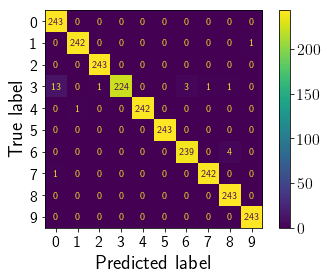

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 187.43it/s]


Classification test report for estimator ESNRegressor(input_to_nodes=[('default',
                              InputToNode(activation='identity',
                                          bias_scaling=0.0,
                                          hidden_layer_size=400,
                                          input_scaling=0.4, k_in=10,
                                          random_state=RandomState(MT19937) at 0x293177A88C8,
                                          sparsity=0.7692307692307693))],
             nodes_to_nodes=[('default',
                              NodeToNode(bias_scaling=0.7,
                                         hidden_layer_size=400, k_rec=10,
                                         leakage=0.1,
                                         random_state=RandomState(MT19937) at 0x293177A87B8,
                                         sparsity=0.025,
                                         spectral_radius=0.6))],
             random_state=RandomState(MT19937) 

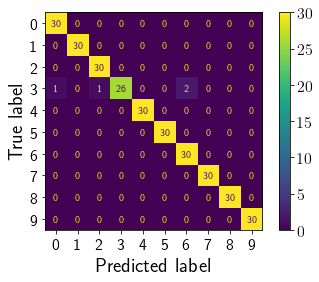

In [77]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))
plt.show()

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

Visualization of a reservoir state from the training set

In [50]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1, cmap='RdBu')
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_kmeans_train.pdf')

TypeError: predict() got an unexpected keyword argument 'keep_reservoir_state'

Visualization of a reservoir state from the test set

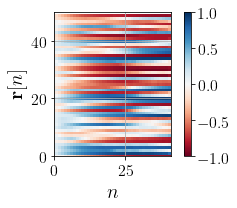

In [88]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1, cmap='RdBu')
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('k_res_kmeans_test.pdf')

Increase the reservoir size

In [85]:
base_input_to_nodes = InputToNode(hidden_layer_size=3000, activation='identity', k_in=10, input_scaling=1.1, bias_scaling=0.0, random_state=1)
base_input_to_nodes.fit(X=X_train_scaled[0])
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
w_in = np.pad(w_in, ((0, 0), (2500, 0)), mode='constant', constant_values=0)
base_input_to_nodes._input_weights = w_in
base_nodes_to_nodes = NodeToNode(hidden_layer_size=3000, activation='tanh', spectral_radius=1.0, leakage=0.1, bias_scaling=1.3, bi_directional=False, k_rec=5, random_state=1)

esn = ESNRegressor(input_to_nodes=[('default', base_input_to_nodes)],
                   nodes_to_nodes=[('default', base_nodes_to_nodes)],
                   regressor=IncrementalRegression(alpha=1e-3), random_state=1)

In [86]:
print("Train the ESN model...")
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        esn.partial_fit(X=X, y=y)
        pbar.update(1)
print("done!")

Train the ESN model...


100%|██████████████████████████████████████████████████████████████████████████████| 2430/2430 [52:11<00:00,  1.28s/it]


done!


Test

In [ ]:
Y_true_train = []
Y_pred_train = []
mse_train = []
mse_test = []
with tqdm(total=len(X_train_scaled)) as pbar:
    for X, y in zip(X_train_scaled, y_train):
        Y_true_train.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_train.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_train.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_train, Y_pred_train)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_train, Y_pred_train, digits=10)))
print("MSE training: %f\n" % (np.mean(mse_train)))
plt.show()

Y_true_test = []
Y_pred_test = []
mse_test = []
with tqdm(total=len(X_test_scaled)) as pbar:
    for X, y in zip(X_test_scaled, y_test):
        Y_true_test.append(y)
        y_pred = esn.predict(X=X)
        Y_pred_test.append(np.argmax(y_pred.sum(axis=0)))
        y = enc.transform(np.asarray(y).reshape(1, -1))
        y = np.repeat(np.atleast_2d(y), repeats=X.shape[0], axis=0)
        mse_test.append(mean_squared_error(y, y_pred))
        pbar.update(1)
cm = confusion_matrix(Y_true_test, Y_pred_test)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot()
print("Classification test report for estimator %s:\n%s\n" % (esn, classification_report(Y_true_test, Y_pred_test, digits=10)))
print("MSE test: %f\n" % (np.mean(mse_test)))
plt.show()

 22%|█████████████████▍                                                             | 538/2430 [00:08<00:32, 57.74it/s]

Visualization of a reservoir state from the training set

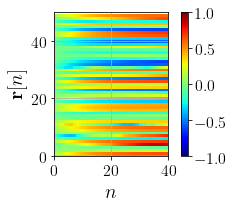

In [43]:
_ = esn.predict(X=X_train_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_train.pdf')

Visualization of a reservoir state from the test set

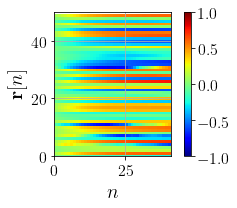

In [44]:
_ = esn.predict(X=X_test_scaled[0], keep_reservoir_state=True)
np.random.seed(0)
index = np.random.choice(esn.reservoir_state.shape[1], 50, replace=False)
plt.figure(figsize=(4, 3))
im = plt.imshow(esn.reservoir_state[:, index].T,vmin=-1, vmax=1)
plt.xlim([0, esn.reservoir_state.shape[0]])
plt.ylim([0, 50])
plt.xlabel(r'$n$')
plt.ylabel(r'$\mathbf{r}[n]$')
plt.colorbar(im)
plt.grid()
plt.tight_layout()
plt.savefig('reservoir_size_kmeans_test.pdf')

Functions to fit KMeans and KMedoids for different settings (K, minibatch)

In [90]:
def fit_k_means(k, mini_batch=False, X=np.ndarray):
    print(k)
    if mini_batch:
        kmeans = MiniBatchKMeans(n_clusters=k, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0)
    else:
        kmeans = MiniBatchKMeans(n_clusters=k, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0)
    kmeans.fit(X=np.vstack(X_train_scaled))
    return kmeans.inertia_

def fit_k_medoids(k):
    kmedoids = KMedoids(n_clusters=k, metric='euclidean',init='k-medoids++', max_iter=300, random_state=0)
    kmedoids.fit(X=np.vstack(X_train_scaled))
    return kmedoids.inertia_


Sweep along various $K$ and compare $K$-means, Mini-batch $K$-means and $K$-medoids

In [97]:
inertias_k_means = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_means)(k, True) for k in [1460])
# silhouette_scores_k_means = [None] * len(range(2, 1001))
# for k in range(2, 10):
#     print(k)
#     silhouette_scores_k_means[k-2] = fit_k_means(k, True, X_train_scaled)
# inertias_k_medoids = Parallel(n_jobs=-1, verbose=50)(delayed(fit_k_medoids)(k) for k in range(10, 501, 10))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   23.9s finished


In [98]:
np.savetxt(X=inertias_k_means, fname="inertias_minibatch_k_means.csv")

Visualization

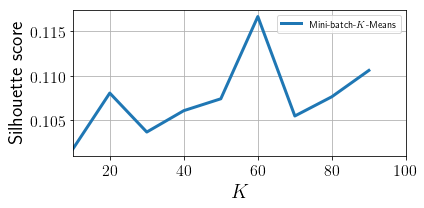

In [15]:
plt.figure(figsize=(6, 3))
# plt.plot(range(10, 1001, 10), inertias_k_means, label=r"$K$-Means")
plt.plot(range(10, 100, 10), silhouette_scores_k_means, label=r"Mini-batch-$K$-Means")
# plt.plot(range(10, 501, 10), inertias_k_medoids, label="$K-\text{Medoids}$")
plt.xlabel(r'$K$')
plt.ylabel(r'Silhouette score')
plt.xlim([10, 100])
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("silhouette_score.pdf")